<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Trabajo de fin de máster</p>
<p style="margin: 0; text-align:right;">Máster Universitario en Ciencia de Datos</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right;">Azucena González Muiño</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Pruebas de *oversampling*

Debido al bajo rendimiento obtenido por el modelo, sobre todo en la precisión de la clase positiva que es además la minoritaria, se aplican varias técnicas de aumento de datos sobre un modelo base.

In [1]:
# Manipulación de datos
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.api.types import is_numeric_dtype

# Construcción y evaluación de modelos
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# Librerías para aumento de datos
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN

# Generación de gráficas
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline

## 0. Definición de funciones

Este apartado recoge varias funciones y constantes o variables globales que se emplean en las siguientes secciones.

In [2]:
# Modificación de opciones por defecto
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.4f}'.format

# Se ignoran los mensajes de aviso
from warnings import filterwarnings
filterwarnings('ignore')

# Etiquetas de clase
labels = ['False', 'True']

# Nombre de la variable objetivo
target = 'Further-action'

# Semilla para la reproducibilidad de resultados
seed = 22

# Función que codifica las variables del dataset según su tipo y divide los datos en los conjuntos de
# entrenamiento, validación y prueba
def prepare_inputs(data, target):
    for f in data.columns:
        # Se aplica one hot encoding a las variables de tipo 'object' y a las categóricas sin ordenación
        if (data[f].dtypes.name == 'object') or (data[f].dtypes.name == 'category' and not data[f].cat.ordered):
            data = pd.get_dummies(data, columns=[f], drop_first=False)
        
        # Los atributos con ordenación se codifican con OrdinalEncoder respetando su prelación
        elif (data[f].dtypes.name == 'category' and data[f].cat.ordered):
            encoder = OrdinalEncoder(categories=[data[f].cat.categories.values], dtype=np.int64)
            tmp = encoder.fit_transform(data[[f]])
            data[f] = encoder.fit_transform(data[[f]])

    # Se realiza la partición de los datos para el conjunto de training y el de test
    X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1), 
                                                        data[target], test_size=0.3, shuffle=False)

    # Se realiza una la división en el conjunto reservado para el entrenamiento entre training y validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=False)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Función que divide los datos en los conjuntos de entrenamiento, validación y prueba
def split_inputs(data, target):
    # Se realiza la partición de los datos para el conjunto de training y el de test
    X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis=1), 
                                                        data[target], test_size=0.3, shuffle=False)

    # Se realiza una la división en el conjunto reservado para el entrenamiento entre training y validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=False)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Función que codifica las variables del dataset según su tipo
def encode_inputs(data):
    for f in data.columns:
        # Se aplica one hot encoding a las variables de tipo 'object' y a las categóricas sin ordenación
        if (data[f].dtypes.name == 'object') or (data[f].dtypes.name == 'category' and not data[f].cat.ordered):
            data = pd.get_dummies(data, columns=[f], drop_first=False)
        
        # Los atributos con ordenación se codifican con OrdinalEncoder respetando su prelación
        elif (data[f].dtypes.name == 'category' and data[f].cat.ordered):
            encoder = OrdinalEncoder(categories=[data[f].cat.categories.values], dtype=np.int64)
            tmp = encoder.fit_transform(data[[f]])
            data[f] = encoder.fit_transform(data[[f]])

    return data

# Función que muestra gráficamente la matriz de confusión recibida como entrada indicando en
# cada celda el número de registros y el porcentaje que representan sobre el total
def conf_matrix_plot(conf_matrix, title='Matriz de confusión', labels=None):
    # Se convierte la matriz a dataframe
    conf_matrix_df = pd.DataFrame(conf_matrix, columns=labels, index=labels)

    # Se generan los textos a mostrar: nombres, total de registros y porcentaje
    # sobre el total
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    ext_labels = [f'{l1}\n{l2}\n{l3}' for l1, l2, l3 in zip(group_names, group_counts, group_percentages)]
    ext_labels = np.asarray(ext_labels).reshape(2, 2)
    
    # Se crea un heatmap con la matriz de confusión
    sns.heatmap(conf_matrix_df, annot=ext_labels, fmt='', cmap='Blues', linewidths=2, cbar_kws={"shrink": .8})
    plt.title(title, fontsize=14)
    plt.ylabel('Valores reales', fontsize=12)
    plt.xlabel('Predicciones', fontsize=12)
    plt.yticks(rotation=0)
    
    return plt

## 1. Carga del conjunto de datos

Se procede a realizar la carga del fichero preparado previamente y que contiene los datos relativos a las actuaciones policiales de tipo "detención y registro" realizadas en Londres durante el periodo de abril de 2017 a febrero de 2021.

In [3]:
# Carga de datos policiales
london_data = pd.read_csv('./datasets/preproc-stop-and-search.csv', parse_dates=['Date'])

# Se muestra la dimensión del dataset, sus columnas y tipos de datos
print('Número de filas totales:', london_data.shape[0])
print('Número de atributos:', london_data.shape[1])
print(london_data.dtypes)

Número de filas totales: 785721
Número de atributos: 21
Type                         object
Date                 datetime64[ns]
Latitude                    float64
Longitude                   float64
Gender                       object
Age-range                    object
Self-ethnicity               object
Officer-ethnicity            object
Legislation                  object
Object                       object
Outcome                      object
Source                       object
Address                      object
Borough                      object
Year-month                   object
Location                       bool
Further-action                 bool
Short-ethnicity              object
Day                           int64
Hour                          int64
Day-of-week                  object
dtype: object


In [4]:
# Se muestra un resumen con las principales características de las variables
london_data.astype('object').describe().transpose()

,count,unique,top,freq
Type,785721,3,Person search,589746
Date,785721,400591,2018-08-27 14:00:00,68
Latitude,"785,721.0","32,954.0",51.3784,"3,365.0"
Longitude,"785,721.0","34,090.0",-0.1027,"3,365.0"
Gender,785721,4,Male,722070
Age-range,785721,6,18-24,275199
Self-ethnicity,785721,17,Other - Not stated,164274
Officer-ethnicity,785721,5,Black,307525
Legislation,785721,5,Misuse of Drugs Act 1971,479183
Object,785721,14,Controlled drugs,479107


In [5]:
# Se comprueba que no hay valores perdidos
print('Valores perdidos en el dataset:', london_data.isnull().sum().sum())

Valores perdidos en el dataset: 0


A continuación se generan dos nuevas variables con información sobre el año y el mes, se indica qué variables son categóricas con orden y se reagrupan algunos de los registros de la variable "Object", dado que el número de posibles valores es elevado y algunas de las categorías son residuales.

In [6]:
# Se incorporan variables para el mes y año
london_data['Month'] = london_data['Date'].dt.month
london_data['Year'] = london_data['Date'].dt.year

# Se marca la variable 'Age-range' como categoría con orden entre sus elementos
age_range_type = CategoricalDtype(categories=['Under 10', '10-17', '18-24', '25-34', 'Over 34', 'Unknown'], 
                                  ordered=True)
london_data['Age-range'] = london_data['Age-range'].astype(age_range_type)

# Se genera una variable a partir de 'Day-of-week' como categoría con orden
dow_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                            ordered=True)
london_data['Dow'] = london_data['Day-of-week'].astype(dow_type)

# Información básica de la variable "Object"
print('Número de valores diferentes:', len(pd.unique(london_data['Object'])))
print(london_data['Object'].value_counts())

Número de valores diferentes: 14
Controlled drugs                              479107
Offensive weapons                             120332
Stolen goods                                   76843
Articles for use in criminal damage            39582
Evidence of offences under the Act             33236
Anything to threaten or harm anyone            25478
Firearms                                        5264
Fireworks                                       2615
Unknown                                         1905
Article for use in theft                        1327
Goods on which duty has not been paid etc.        13
Psychoactive substances                           10
Crossbows                                          8
Evidence of wildlife offences                      1
Name: Object, dtype: int64


In [7]:
# Se modifica la variable "Object" para reducir el número de valores, dado que algunos de ellos son residuales
objects = london_data['Object'].value_counts().nsmallest(7).keys()
london_data['Object'] = london_data['Object'].apply(lambda x: 'Others' if x in objects else x)
print(london_data['Object'].value_counts())

Controlled drugs                       479107
Offensive weapons                      120332
Stolen goods                            76843
Articles for use in criminal damage     39582
Evidence of offences under the Act      33236
Anything to threaten or harm anyone     25478
Others                                   5879
Firearms                                 5264
Name: Object, dtype: int64


Se genera además una nueva variable que incorpora el número de actuaciones policiales con resultado positivo por distrito para el mes anterior.

In [8]:
# Se cuentan las actuaciones positivas por distrito y mes-año
fa_by_month_borough = london_data.groupby(['Year-month', 'Borough'], as_index=False)['Further-action'].sum()
fa_by_month_borough.rename(columns={'Further-action':'Last-month-fa'}, inplace=True)
fa_by_month_borough['Year-month'] = fa_by_month_borough['Year-month'].astype(str)

# Se reutiliza la variable creada como apoyo en el análisis exploratorio para obtener el mes anterior de
# cada registro
london_data['Year-month'] = (london_data['Date']+pd.DateOffset(months=-1)).dt.to_period('M').astype(str)
london_data = pd.merge(london_data, fa_by_month_borough, how='left', on=['Year-month', 'Borough'])

# Los registros del primer mes de datos no contienen información, por lo que se inicializan a 0
london_data['Last-month-fa'] = london_data['Last-month-fa'].fillna(0)

Algunas de las variables no se van a utilizar en la construcción del modelo, bien porque están claramente relacionadas con otras ya existentes, bien porque se han empleado en la definición de la variable objetivo (*Further-action*).

In [9]:
# Se descartan las siguientes variables:

# 'Outcome', pues se ha utilizado como base para generar la variable objetivo
london_data = london_data.drop('Outcome', axis=1)

# Location y Year-month, variables auxiliares creadas para el análisis exploratorio
london_data = london_data.drop(['Location', 'Year-month'], axis=1)

# La dirección completa, puesto que esa información ya aparece recogida en las coordenadas geográficas
london_data = london_data.drop('Address', axis=1)

# El día de la semana, dado que se ha generado una categórica con orden derivada de ella
london_data = london_data.drop('Day-of-week', axis=1)

# Self-ethnicity, debido al alto número de categorías y de valores desconocidos: además, se cuenta con
# otra variable derivada de esta, Short-ethnicity, con la información simplificada
london_data = london_data.drop('Self-ethnicity', axis=1)

Al tratarse de datos con carácter temporal, es importante considerar el momento en que tuvieron lugar. Por ello, el conjunto se ordena por fecha, de menos a más reciente, y las particiones para los conjuntos de datos se realizarán manteniendo ese orden. El conjunto de entrenamiento tendrá los registros más antiguos y el de prueba los más recientes. 

In [10]:
# Antes de realizar la división en conjuntos de entrenamiento, validación y prueba, se ordenan los
# registros por fecha
london_data.sort_values(by=['Date'], inplace=True)
london_data = london_data.drop('Date', axis=1)
london_data.reset_index(inplace=True, drop=True)

In [11]:
# Se revisa cómo queda el conjunto de datos tras los cambios
london_data.tail()

,Type,Latitude,Longitude,Gender,Age-range,Officer-ethnicity,Legislation,Object,Source,Borough,Further-action,Short-ethnicity,Day,Hour,Month,Year,Dow,Last-month-fa
785716,Person and Vehicle search,51.5230,-0.1937,Male,Unknown,Asian,Criminal Justice and Public Order Act 1994,Anything to threaten or harm anyone,MET,Westminster,False,Unknown,28,23,2,2021,Sunday,339.0000
785717,Person search,51.5230,-0.1937,Male,18-24,Other,Criminal Justice and Public Order Act 1994,Anything to threaten or harm anyone,MET,Westminster,False,Unknown,28,23,2,2021,Sunday,339.0000
785718,Person search,51.5582,-0.0081,Male,18-24,Asian,Misuse of Drugs Act 1971,Controlled drugs,MET,Waltham Forest,False,Asian,28,23,2,2021,Sunday,139.0000
785719,Person and Vehicle search,51.3680,-0.0988,Male,Over 34,Black,Misuse of Drugs Act 1971,Controlled drugs,MET,Croydon,True,Black,28,23,2,2021,Sunday,222.0000
785720,Person and Vehicle search,51.5582,-0.0081,Male,18-24,Asian,Misuse of Drugs Act 1971,Controlled drugs,MET,Waltham Forest,False,Asian,28,23,2,2021,Sunday,139.0000


## 2. Random Oversampling

En este apartado se evalúa un modelo base con la técnica de aumento de datos *random oversampling*.

In [12]:
# Se emplea TimeSeriesSplit para entrenar con validación cruzada en series temporales
tscv = TimeSeriesSplit(n_splits=5)

# Se preparan los datos
X_train, X_val, X_test, y_train, y_val, y_test = prepare_inputs(london_data.copy(deep=True), target)

# Se generan los datos aumentados
ros = RandomOverSampler(random_state=seed)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
X_train_resampled.head()

,Latitude,Longitude,Age-range,Day,Hour,Month,Year,Dow,Last-month-fa,Type_Person and Vehicle search,Type_Person search,Type_Vehicle search,Gender_Female,Gender_Male,Gender_Other,Gender_Unknown,Officer-ethnicity_Asian,Officer-ethnicity_Black,Officer-ethnicity_Other,Officer-ethnicity_Unknown,Officer-ethnicity_White,Legislation_Criminal Justice and Public Order Act 1994,Legislation_Firearms Act 1968,Legislation_Misuse of Drugs Act 1971,Legislation_Other or unknown,Legislation_Police and Criminal Evidence Act 1984,Object_Anything to threaten or harm anyone,Object_Articles for use in criminal damage,Object_Controlled drugs,Object_Evidence of offences under the Act,Object_Firearms,Object_Offensive weapons,Object_Others,Object_Stolen goods,Source_BTP,Source_CLP,Source_MET,Borough_Barking and Dagenham,Borough_Barnet,Borough_Bexley,Borough_Brent,Borough_Bromley,Borough_Camden,Borough_City of London,Borough_Croydon,Borough_Ealing,Borough_Enfield,Borough_Greenwich,Borough_Hackney,Borough_Hammersmith and Fulham,Borough_Haringey,Borough_Harrow,Borough_Havering,Borough_Hillingdon,Borough_Hounslow,Borough_Islington,Borough_Kensington and Chelsea,Borough_Kingston upon Thames,Borough_Lambeth,Borough_Lewisham,Borough_Merton,Borough_Newham,Borough_Redbridge,Borough_Richmond upon Thames,Borough_Southwark,Borough_Sutton,Borough_Tower Hamlets,Borough_Waltham Forest,Borough_Wandsworth,Borough_Westminster,Short-ethnicity_Asian,Short-ethnicity_Black,Short-ethnicity_Other,Short-ethnicity_Unknown,Short-ethnicity_White
0,51.4724,-0.3934,2,1,0,4,2017,5,0.0000,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,51.5932,-0.0998,2,1,0,4,2017,5,0.0000,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,51.4637,-0.1306,5,1,0,4,2017,5,0.0000,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,51.5854,-0.0786,4,1,0,4,2017,5,0.0000,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,51.4764,-0.1055,2,1,0,4,2017,5,0.0000,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


F1-score (validación cruzada) para random oversampling: 0.566246 (desviación: 0.096)
              precision    recall  f1-score   support

       False       0.79      0.75      0.77    127303
        True       0.27      0.31      0.29     37699

    accuracy                           0.65    165002
   macro avg       0.53      0.53      0.53    165002
weighted avg       0.67      0.65      0.66    165002



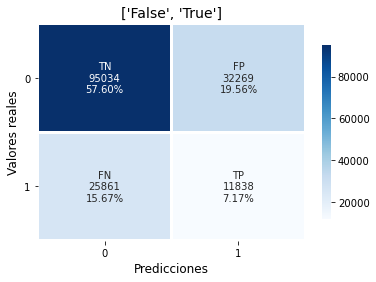

In [13]:
# Modelo de referencia
bl_model = DecisionTreeClassifier(random_state=seed)
ros_scores = cross_val_score(bl_model, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=tscv)

print('F1-score (validación cruzada) para random oversampling: %f (desviación: %.3f)' % (ros_scores.mean(), ros_scores.std()))

# Entrenamiento del modelo
bl_model.fit(X_train_resampled, y_train_resampled)

# Se aplica el modelo sobre el conjunto de validación
y_pred = bl_model.predict(X_val)

# Se muestran sus métricas y su matriz de confusión
conf_matrix = metrics.confusion_matrix(y_val, y_pred)
class_metrics = metrics.classification_report(y_val, y_pred, output_dict=True)
print(metrics.classification_report(y_val, y_pred, output_dict=False))
conf_matrix_plot(conf_matrix, labels).show()

## 3. SMOTE

En este apartado se evalúa un modelo base con la técnica de aumento de datos *SMOTE*.

In [14]:
# Se separan los datos en los conjuntos de entrenamiento, validación y prueba
X_train, X_val, X_test, y_train, y_val, y_test = split_inputs(london_data.copy(deep=True), target)

# Se generan los datos aumentados
categorical_features = X_train.dtypes.apply(lambda x: not is_numeric_dtype(x))
smote = SMOTENC(categorical_features=categorical_features, random_state=seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled.head()

,Type,Latitude,Longitude,Gender,Age-range,Officer-ethnicity,Legislation,Object,Source,Borough,Short-ethnicity,Day,Hour,Month,Year,Dow,Last-month-fa
0,Person and Vehicle search,51.4724,-0.3934,Female,18-24,White,Police and Criminal Evidence Act 1984,Articles for use in criminal damage,MET,Hounslow,White,1,0,4,2017,Saturday,0.0000
1,Person search,51.5932,-0.0998,Male,18-24,Black,Misuse of Drugs Act 1971,Controlled drugs,MET,Haringey,Black,1,0,4,2017,Saturday,0.0000
2,Person search,51.4637,-0.1306,Male,Unknown,Black,Police and Criminal Evidence Act 1984,Articles for use in criminal damage,MET,Lambeth,Black,1,0,4,2017,Saturday,0.0000
3,Person and Vehicle search,51.5854,-0.0786,Male,Over 34,Black,Misuse of Drugs Act 1971,Controlled drugs,MET,Haringey,Black,1,0,4,2017,Saturday,0.0000
4,Person and Vehicle search,51.4764,-0.1055,Male,18-24,Black,Misuse of Drugs Act 1971,Controlled drugs,MET,Lambeth,Unknown,1,0,4,2017,Saturday,0.0000


F1-score (validación cruzada) para SMOTE: 0.486411 (desviación: 0.050)
              precision    recall  f1-score   support

       False       0.79      0.66      0.72    127303
        True       0.26      0.41      0.32     37699

    accuracy                           0.61    165002
   macro avg       0.53      0.54      0.52    165002
weighted avg       0.67      0.61      0.63    165002



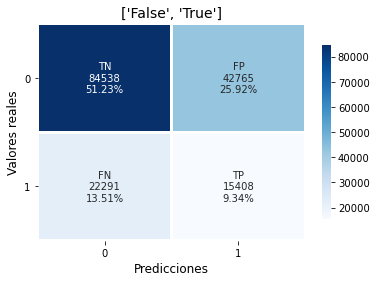

In [15]:
# Tras aplicar SMOTE, es preciso codificar previamente las variables categóricas
X_train_resampled = encode_inputs(X_train_resampled)
X_val = encode_inputs(X_val)

# Modelo de referencia
bl_model = DecisionTreeClassifier(random_state=seed)
ros_scores = cross_val_score(bl_model, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=tscv)

print('F1-score (validación cruzada) para SMOTE: %f (desviación: %.3f)' % (ros_scores.mean(), ros_scores.std()))

# Entrenamiento del modelo
bl_model.fit(X_train_resampled, y_train_resampled)

# Se aplica el modelo sobre el conjunto de validación
y_pred = bl_model.predict(X_val)

# Se muestran sus métricas y su matriz de confusión
conf_matrix = metrics.confusion_matrix(y_val, y_pred)
class_metrics = metrics.classification_report(y_val, y_pred, output_dict=True)
print(metrics.classification_report(y_val, y_pred, output_dict=False))
conf_matrix_plot(conf_matrix, labels).show()

## 4. ADASYN

En este apartado se evalúa un modelo base con la técnica de aumento de datos *ADASYN*.

In [16]:
# Se preparan los datos, codificando las variables categóricas con ordinal o one hot encoding
X_train, X_val, X_test, y_train, y_val, y_test = prepare_inputs(london_data.copy(deep=True), target)

# Se generan los datos aumentados
adasyn = ADASYN(random_state=seed)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
X_train_resampled.head()

,Latitude,Longitude,Age-range,Day,Hour,Month,Year,Dow,Last-month-fa,Type_Person and Vehicle search,Type_Person search,Type_Vehicle search,Gender_Female,Gender_Male,Gender_Other,Gender_Unknown,Officer-ethnicity_Asian,Officer-ethnicity_Black,Officer-ethnicity_Other,Officer-ethnicity_Unknown,Officer-ethnicity_White,Legislation_Criminal Justice and Public Order Act 1994,Legislation_Firearms Act 1968,Legislation_Misuse of Drugs Act 1971,Legislation_Other or unknown,Legislation_Police and Criminal Evidence Act 1984,Object_Anything to threaten or harm anyone,Object_Articles for use in criminal damage,Object_Controlled drugs,Object_Evidence of offences under the Act,Object_Firearms,Object_Offensive weapons,Object_Others,Object_Stolen goods,Source_BTP,Source_CLP,Source_MET,Borough_Barking and Dagenham,Borough_Barnet,Borough_Bexley,Borough_Brent,Borough_Bromley,Borough_Camden,Borough_City of London,Borough_Croydon,Borough_Ealing,Borough_Enfield,Borough_Greenwich,Borough_Hackney,Borough_Hammersmith and Fulham,Borough_Haringey,Borough_Harrow,Borough_Havering,Borough_Hillingdon,Borough_Hounslow,Borough_Islington,Borough_Kensington and Chelsea,Borough_Kingston upon Thames,Borough_Lambeth,Borough_Lewisham,Borough_Merton,Borough_Newham,Borough_Redbridge,Borough_Richmond upon Thames,Borough_Southwark,Borough_Sutton,Borough_Tower Hamlets,Borough_Waltham Forest,Borough_Wandsworth,Borough_Westminster,Short-ethnicity_Asian,Short-ethnicity_Black,Short-ethnicity_Other,Short-ethnicity_Unknown,Short-ethnicity_White
0,51.4724,-0.3934,2,1,0,4,2017,5,0.0000,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,51.5932,-0.0998,2,1,0,4,2017,5,0.0000,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,51.4637,-0.1306,5,1,0,4,2017,5,0.0000,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,51.5854,-0.0786,4,1,0,4,2017,5,0.0000,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,51.4764,-0.1055,2,1,0,4,2017,5,0.0000,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


F1-score (validación cruzada) para ADASYN: 0.456500 (desviación: 0.093)
              precision    recall  f1-score   support

       False       0.79      0.72      0.75    127303
        True       0.27      0.35      0.30     37699

    accuracy                           0.63    165002
   macro avg       0.53      0.53      0.53    165002
weighted avg       0.67      0.63      0.65    165002



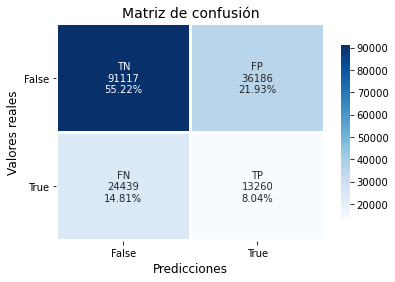

In [17]:
# Modelo de referencia
bl_model = DecisionTreeClassifier(random_state=seed)
ros_scores = cross_val_score(bl_model, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=tscv)

print('F1-score (validación cruzada) para ADASYN: %f (desviación: %.3f)' % (ros_scores.mean(), ros_scores.std()))

# Entrenamiento del modelo
bl_model.fit(X_train_resampled, y_train_resampled)

# Se aplica el modelo sobre el conjunto de validación
y_pred = bl_model.predict(X_val)

# Se muestran sus métricas y su matriz de confusión
conf_matrix = metrics.confusion_matrix(y_val, y_pred)
class_metrics = metrics.classification_report(y_val, y_pred, output_dict=True)
print(metrics.classification_report(y_val, y_pred, output_dict=False))
conf_matrix_plot(conf_matrix, 'Matriz de confusión', labels).show()

Ninguna de las técnicas aplicadas ha conseguido mejorar el rendimiento del modelo base. Por tanto, y dado que las técnicas de aumento de datos incrementan el coste computacional de la solución e incorporan ruido a los datos de entrada al tratarse de información generada sintéticamente, se decide no emplear ninguno de estos métodos en la construcción del modelo.